總績效 -0.1082 
交易次數 152 
平均績效 -0.0007 
平均持有天數 7 天
勝率 0.49 
平均獲利 0.0149 
平均虧損 -0.0159 
賺賠比 0.9358 
期望值 -0.0448 
獲利平均持有天數 7 天
虧損平均持有天數 8 天
最大連續虧損 -0.0741
最大資金回落 0.242


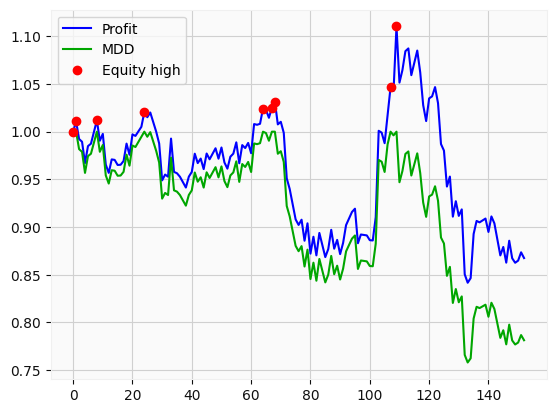

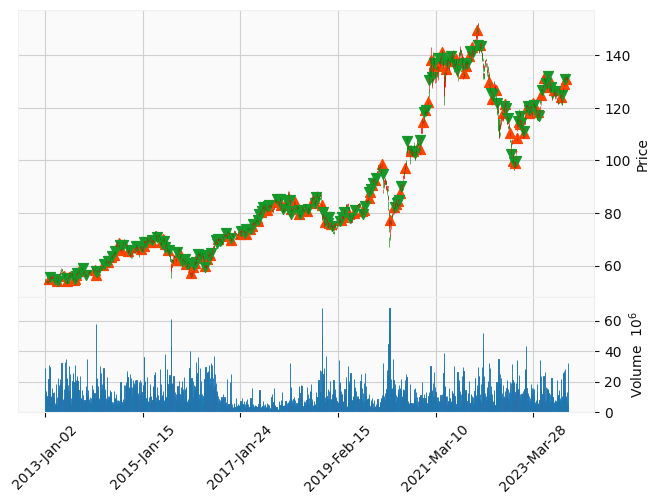

In [5]:
# 載入必要套件
import pandas as pd
import yfinance as yf
import os
import mplfinance as mpf
import matplotlib.pyplot as plt

'''自訂函數'''


# 計算交易績效指標
def Performance(trade=pd.DataFrame(), prodtype="ETF"):
    # 如果沒有交易紀錄 則不做接下來的計算
    if trade.shape[0] == 0:
        print("沒有交易紀錄")
        return False

    # 交易成本 手續費0.1425%*2 (券商打折請自行計算)
    if prodtype == "ETF":
        cost = 0.001 + 0.00285  # ETF稅金 0.1%
    elif prodtype == "Stock":
        cost = 0.003 + 0.00285  # 股票的稅金 0.3%
    else:
        return False

    # 將物件複製出來，不影響原本的變數內容
    trade1 = trade.copy()
    trade1 = trade1.sort_values(4)
    trade1 = trade1.reset_index(drop=True)

    # 給交易明細定義欄位名稱
    trade1.columns = [
        "product",
        "bs",
        "order_time",
        "order_price",
        "cover_time",
        "cover_price",
        "order_unit",
    ]
    # 計算出每筆的報酬率
    trade1["ret"] = (
        ((trade1["cover_price"] - trade1["order_price"]) / trade1["order_price"]) - cost
    ) * trade1["order_unit"]

    # 1.	總報酬率：整個回測期間的總報酬率累加
    print("總績效 %s " % (round(trade1["ret"].sum(), 4)))
    # 2.	總交易次數：代表回測的交易筆數
    print("交易次數 %s " % (trade1.shape[0]))
    # 3.	平均報酬率：簡單平均報酬率（扣除交易成本後）
    print("平均績效 %s " % (round(trade1["ret"].mean(), 4)))
    # 4.    平均持有時間：代表平均每筆交易的持有時間
    onopen_day = (trade1["cover_time"] - trade1["order_time"]).mean()
    print("平均持有天數 %s 天" % (onopen_day.days))
    # 判斷是否獲利跟虧損都有績效
    earn_trade = trade1[trade1["ret"] > 0]
    loss_trade = trade1[trade1["ret"] <= 0]
    if earn_trade.shape[0] == 0 or loss_trade.shape[0] == 0:
        print("交易資料樣本不足(樣本中需要賺有賠的)")
        return False
    # 5.	勝率：代表在交易次數中，獲利次數的佔比（扣除交易成本後）
    earn_ratio = earn_trade.shape[0] / trade1.shape[0]
    print("勝率 %s " % (round(earn_ratio, 2)))
    # 6.	平均獲利：代表平均每一次獲利的金額（扣除交易成本後）
    avg_earn = earn_trade["ret"].mean()
    print("平均獲利 %s " % (round(avg_earn, 4)))
    # 7.	平均虧損：代表平均每一次虧損的金額（扣除交易成本後）
    avg_loss = loss_trade["ret"].mean()
    print("平均虧損 %s " % (round(avg_loss, 4)))
    # 8.	賺賠比：代表平均獲利 / 平均虧損
    odds = abs(avg_earn / avg_loss)
    print("賺賠比 %s " % (round(odds, 4)))
    # 9.	期望值：代表每投入的金額，可能會回報的多少倍的金額
    print("期望值 %s " % (round(((earn_ratio * odds) - (1 - earn_ratio)), 4)))
    # 10.	獲利平均持有時間：代表獲利平均每筆交易的持有時間
    earn_onopen_day = (earn_trade["cover_time"] - earn_trade["order_time"]).mean()
    print("獲利平均持有天數 %s 天" % (earn_onopen_day.days))
    # 11.	虧損平均持有時間：代表虧損平均每筆交易的持有時間
    loss_onopen_day = (loss_trade["cover_time"] - loss_trade["order_time"]).mean()
    print("虧損平均持有天數 %s 天" % (loss_onopen_day.days))

    # 12.	最大連續虧損：代表連續虧損的最大幅度
    tmp_accloss = 1
    max_accloss = 1
    for ret in trade1["ret"].values:
        if ret <= 0:
            tmp_accloss *= ret
            max_accloss = min(max_accloss, tmp_accloss)
        else:
            tmp_accloss = 1
    print("最大連續虧損", round(max_accloss, 4))

    # 優先計算累計報酬率 並將累計報酬率的初始值改為1 繪圖較容易閱讀
    trade1["acc_ret"] = (1 + trade1["ret"]).cumprod()
    trade1.loc[-1, "acc_ret"] = 1
    trade1.index = trade1.index + 1
    trade1.sort_index(inplace=True)

    # 13.	最大資金回落：代表資金從最高點回落至最低點的幅度
    trade1["acc_max_cap"] = trade1["acc_ret"].cummax()
    trade1["dd"] = trade1["acc_ret"] / trade1["acc_max_cap"]
    trade1.loc[trade1["acc_ret"] == trade1["acc_max_cap"], "new_high"] = trade1[
        "acc_ret"
    ]
    print("最大資金回落", round(1 - trade1["dd"].min(), 4))

    # 14.	繪製資金曲線圖(用幾何報酬計算)
    ax = plt.subplot(111)
    ax.plot(trade1["acc_ret"], "b-", label="Profit")
    ax.plot(trade1["dd"], "-", color="#00A600", label="MDD")
    ax.plot(trade1["new_high"], "o", color="#FF0000", label="Equity high")
    ax.legend()
    plt.show()

    return trade1


# 繪製交易記錄圖
def ChartTrade(data, trade=pd.DataFrame(), addp=[], v_enable=True):
    addp = addp.copy()
    data1 = data.copy()
    # 如果有交易紀錄，則把交易紀錄與K線彙整
    if trade.shape[0] > 0:
        # 將物件複製出來，不影響原本的交易明細變數
        trade1 = trade.copy()
        # 取出進場明細，透過時間索引將資料合併
        buy_order_trade = trade1[[2, 3]]
        buy_order_trade = buy_order_trade.set_index(2)
        buy_order_trade.columns = ["buy_order"]
        buy_order_trade = buy_order_trade.drop_duplicates()
        # 取出出場明細，透過時間索引將資料合併
        buy_cover_trade = trade1[[4, 5]]
        buy_cover_trade = buy_cover_trade.set_index(4)
        buy_cover_trade.columns = ["buy_cover"]
        buy_cover_trade = buy_cover_trade.drop_duplicates()
        # 將交易紀錄與K線資料彙整
        data1 = pd.concat([data1, buy_order_trade, buy_cover_trade], axis=1)

        # 將交易紀錄透過副圖的方式繪製
        addp.append(
            mpf.make_addplot(
                data1["buy_order"],
                type="scatter",
                color="#FF4500",
                marker="^",
                markersize=50,
            )
        )
        addp.append(
            mpf.make_addplot(
                data1["buy_cover"],
                type="scatter",
                color="#16982B",
                marker="v",
                markersize=50,
            )
        )
    # 繪製圖表
    mcolor = mpf.make_marketcolors(up="r", down="g", inherit=True)
    mstyle = mpf.make_mpf_style(base_mpf_style="yahoo", marketcolors=mcolor)
    mpf.plot(data1, addplot=addp, style=mstyle, type="candle", volume=v_enable)


# 取得資料：本地或是 Yahoo
def getDataFM(prod, st, en):
    # 檔案路徑
    bakfile = f"data/YF_{prod}_{st}_{en}_stock_daily_adj.csv"
    # 假如已經有 Excel 資料檔案
    if os.path.exists(bakfile):
        # 讀取 Excel 資料檔案
        data = pd.read_csv(bakfile, index_col="Date", parse_dates=True)
    # 假如 Excel 資料檔案不存在
    else:
        # 透過 yf 下載
        data = yf.download(f"{prod}.TW", start=st, end=en)
        # 下載的資料是英文的，處理欄位名稱，轉換為小寫
        # 轉換部分不包含索引，所以日期還是大寫開頭的 Date
        data.columns = [i.lower() for i in data.columns]
        # 假如下載後沒有資料
        if data.empty:
            print("無法從 Yahoo Finance 下載資料")
            # 傳回一個空的 pd
            return pd.DataFrame()
        # 假如資料 data 不是空的，依照指定路徑存擋
        data.to_csv(bakfile)
    # 存檔後，傳回資料
    return data


# 取得回測資料
prod = "0050"
data = getDataFM(prod, "2013-01-01", "2023-12-15")

# 初始部位
position = 0
trade = pd.DataFrame()
# 開始回測
for i in range(data.shape[0] - 1):
    # 取得策略會應用到的變數
    c_time = data.index[i]
    c_low = data.loc[c_time, "low"]
    c_high = data.loc[c_time, "high"]
    c_close = data.loc[c_time, "close"]
    c_open = data.loc[c_time, "open"]
    # 取下一期資料做為進場資料
    n_time = data.index[i + 1]
    n_open = data.loc[n_time, "open"]

    # 進場程序
    if position == 0:
        # 進場邏輯
        if c_close > c_open and (c_close - c_open) * 2 < (c_open - c_low):
            position = 1
            order_i = i
            order_time = n_time
            order_price = n_open
            order_unit = 1
    # 出場程序
    elif position == 1:
        # 出場邏輯
        if i > order_i + 3 and c_close > c_open:
            position = 0
            cover_time = n_time
            cover_price = n_open
            # 交易紀錄
            trade = trade._append(
                pd.Series(
                    [
                        prod,
                        "Buy",
                        order_time,
                        order_price,
                        cover_time,
                        cover_price,
                        order_unit,
                    ]
                ),
                ignore_index=True,
            )

# 績效分析
Performance(trade, "ETF")
# 繪製K線圖與交易明細
ChartTrade(data, trade)
